<a href="https://colab.research.google.com/github/maclandrol/cours-ia-med/blob/master/04_Classification_Texte_Medical_Francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Classification de Texte Médical Français

**Enseignant:** Emmanuel Noutahi, PhD

---

**Objectif:** Apprendre à classifier des textes médicaux en français en utilisant des approches de prompting et d'apprentissage automatique.

**Dataset:** FrenchMedMCQA - Questions à choix multiples de pharmacie

**Approches:**
- Prompting avec ChatGPT
- Classification automatique avec CamemBERT

## Installation et Configuration

In [1]:
!pip install "datasets<4.0.0" transformers torch pandas scikit-learn matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositif: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.8 MB/s eta 0:00:00
Dispositif: cuda


## 1. Accès aux Données

In [2]:
# Chargement du dataset FrenchMedMCQA
dataset = load_dataset("qanastek/frenchmedmcqa")
print(f"Dataset chargé: {len(dataset['train'])} exemples")

README.md: 0.00B [00:00, ?B/s]

frenchmedmcqa.py: 0.00B [00:00, ?B/s]

The repository for qanastek/frenchmedmcqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/qanastek/frenchmedmcqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


DEFT-2023-FULL.zip:   0%|          | 0.00/550k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset chargé: 2171 exemples


## 2. Transformation en DataFrame

In [3]:
# Conversion en DataFrame
df = pd.DataFrame(dataset['train'])
print(f"DataFrame: {df.shape}")
print(f"Colonnes: {list(df.columns)}")

DataFrame: (2171, 9)
Colonnes: ['id', 'question', 'answer_a', 'answer_b', 'answer_c', 'answer_d', 'answer_e', 'correct_answers', 'number_correct_answers']


## 3. Analyse des Données

In [4]:
# Statistiques de base
print(f"Nombre de questions: {len(df)}")
print(f"Longueur moyenne des questions: {df['question'].str.len().mean():.0f} caractères")

# Distribution des réponses correctes
answer_counts = df['number_correct_answers'].value_counts().sort_index()
print("\\nNombre de bonnes réponses par question:")
for nb, count in answer_counts.items():
    print(f"  {nb} réponse(s): {count} questions")

Nombre de questions: 2171
Longueur moyenne des questions: 100 caractères
\nNombre de bonnes réponses par question:
  0 réponse(s): 595 questions
  1 réponse(s): 528 questions
  2 réponse(s): 718 questions
  3 réponse(s): 296 questions
  4 réponse(s): 34 questions


In [5]:
# Exemple de question
exemple = df.iloc[0]
print("Exemple de question:")
print(f"Q: {exemple['question']}")
print(f"A: {exemple['answer_a']}")
print(f"B: {exemple['answer_b']}")
print(f"C: {exemple['answer_c']}")
print(f"D: {exemple['answer_d']}")
print(f"E: {exemple['answer_e']}")
print(f"Réponses correctes: {exemple['correct_answers']}")

Exemple de question:
Q: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha
A: Sont formées de noyaux d'hélium
B: Sont peu pénétrantes
C: Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D: Sont arrêtées par une feuille de papier
E: Sont peu ionisantes
Réponses correctes: [4]


## 4. Prompting avec ChatGPT

### Le Rôle du Prompting

Le prompting consiste à formuler des instructions claires pour guider un modèle de langue vers la réponse souhaitée. Pour les questions médicales, un bon prompt doit:
- Définir le rôle d'expert médical
- Préciser le format de réponse attendu
- Fournir le contexte nécessaire

### Prompt Simple

In [6]:
# Génération d'un prompt simple
def generer_prompt_simple(question, options):
    options_text = "\n".join([f"{chr(65+i)}. {option}" for i, option in enumerate(options)])

    prompt = f"""Tu es un expert médical français. Pour cette question d'examen de pharmacie, indique toutes les réponses correctes.

Question: {question}

Options:
{options_text}

Réponses correctes (lettres uniquement):"""

    return prompt

# Test avec notre exemple (toutes les 5 options A, B, C, D, E)
options_exemple = [exemple['answer_'+pos] for pos in ["a", "b", "c", "d", "e"]]
prompt_simple = generer_prompt_simple(exemple['question'], options_exemple)
print("PROMPT SIMPLE À COPIER DANS CHATGPT:")
print("=" * 50)
print(prompt_simple)
print("=" * 50)

PROMPT SIMPLE À COPIER DANS CHATGPT:
Tu es un expert médical français. Pour cette question d'examen de pharmacie, indique toutes les réponses correctes.

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha

Options:
A. Sont formées de noyaux d'hélium
B. Sont peu pénétrantes
C. Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D. Sont arrêtées par une feuille de papier
E. Sont peu ionisantes

Réponses correctes (lettres uniquement):


### Prompt Few-Shot (Apprentissage en Contexte)

L'apprentissage en contexte (in-context learning) consiste à fournir quelques exemples dans le prompt pour guider le modèle. Cette technique améliore souvent les performances sans nécessiter d'entraînement.

In [7]:
def generer_prompt_few_shot(question, options):
    options_text = "\n".join([f"{chr(65+i)}. {option}" for i, option in enumerate(options)])

    prompt = f"""Tu es un expert médical français. Voici des exemples de questions d'examen de pharmacie avec leurs réponses correctes:

Exemple 1:
Question: Quels sont les effets indésirables de l'aspirine?
Options:
A. Troubles digestifs
B. Amélioration de l'humeur
C. Risque hémorragique
D. Augmentation de l'appétit
E. Réactions allergiques
Réponses correctes: A, C, E

Exemple 2:
Question: Le paracétamol est contre-indiqué en cas de:
Options:
A. Insuffisance hépatique sévère
B. Hypertension artérielle
C. Diabète
D. Grossesse
E. Insuffisance rénale chronique
Réponses correctes: A

Maintenant, réponds à cette nouvelle question:

Question: {question}

Options:
{options_text}

Réponses correctes (lettres uniquement):"""

    return prompt

# Test few-shot avec toutes les 5 options
prompt_few_shot = generer_prompt_few_shot(exemple['question'], options_exemple)
print("PROMPT FEW-SHOT À COPIER DANS CHATGPT:")
print("=" * 50)
print(prompt_few_shot)
print("=" * 50)

PROMPT FEW-SHOT À COPIER DANS CHATGPT:
Tu es un expert médical français. Voici des exemples de questions d'examen de pharmacie avec leurs réponses correctes:

Exemple 1:
Question: Quels sont les effets indésirables de l'aspirine?
Options:
A. Troubles digestifs
B. Amélioration de l'humeur
C. Risque hémorragique
D. Augmentation de l'appétit
E. Réactions allergiques
Réponses correctes: A, C, E

Exemple 2:
Question: Le paracétamol est contre-indiqué en cas de:
Options:
A. Insuffisance hépatique sévère
B. Hypertension artérielle
C. Diabète
D. Grossesse
E. Insuffisance rénale chronique
Réponses correctes: A

Maintenant, réponds à cette nouvelle question:

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha

Options:
A. Sont formées de noyaux d'hélium
B. Sont peu pénétrantes
C. Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D. Sont arrêtées par une feuille de papier
E. Sont peu ioni

## 5. Classification Automatique

### Préparation des Données

In [8]:
# Préparation des données pour classification binaire (simplifiée)
# Prédire si chaque option est correcte ou non

def preparer_donnees_classification(df, max_samples=500):
    df_sample = df.head(max_samples).copy()

    texts = []
    labels = []

    for _, row in df_sample.iterrows():
        question = row['question']
        options = [row['answer_a'], row['answer_b'], row['answer_c'], row['answer_d'], row['answer_e']]
        correct_answers = row['correct_answers']

        # Pour chaque option, créer un exemple
        for i, option in enumerate(options):
            text = f"{question} [SEP] {option}"
            texts.append(text)

            # Label: 1 si cette option est correcte, 0 sinon
            label = 1 if i in correct_answers else 0
            labels.append(label)

    return texts, labels

texts, labels = preparer_donnees_classification(df, max_samples=500)
print(f"Données préparées: {len(texts)} exemples")
print(f"Labels positifs: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"Options par question: A, B, C, D, E (5 options)")

Données préparées: 2500 exemples
Labels positifs: 1256 (50.2%)
Options par question: A, B, C, D, E (5 options)


=== DIVISION DES DONNÉES ===
Données d'entraînement: 2000 exemples
Données de validation: 250 exemples
Données de test: 250 exemples

Vérification stratification:
Train - moyenne labels/question: 0.50
Validation - moyenne labels/question: 0.50
Test - moyenne labels/question: 0.50


NameError: name 'option_names' is not defined

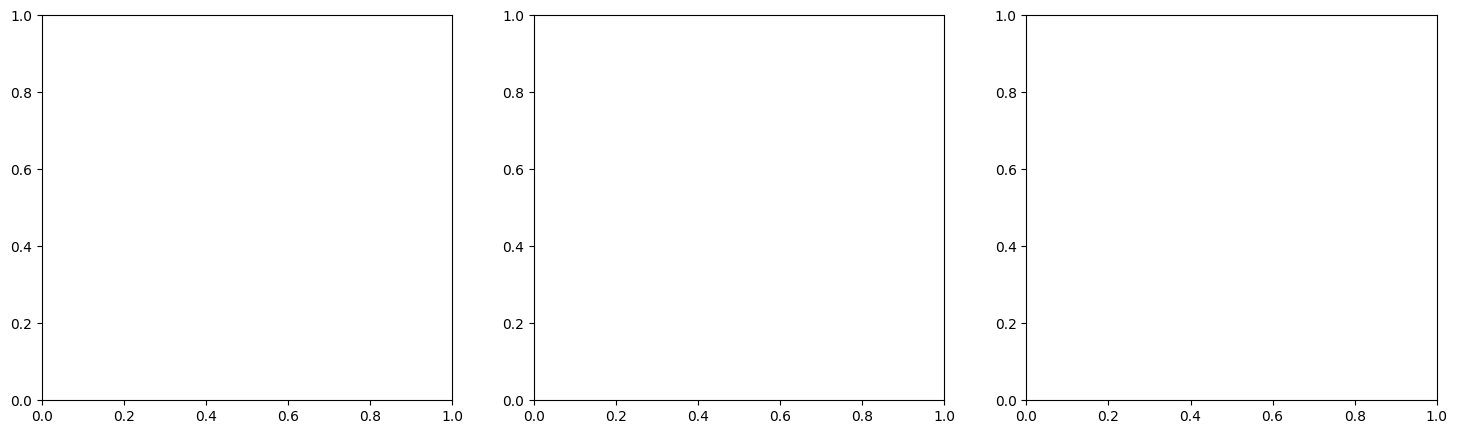

In [17]:
# Division des données en train/validation/test
from sklearn.model_selection import train_test_split

print("=== DIVISION DES DONNÉES ===")

# Division initiale train/temp (80/20)
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Division temp en validation/test (10/10 du total)
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
)

print(f"Données d'entraînement: {len(texts_train)} exemples")
print(f"Données de validation: {len(texts_val)} exemples")
print(f"Données de test: {len(texts_test)} exemples")

# Vérification de la distribution stratifiée
train_avg_labels = np.array(labels_train).mean()
val_avg_labels = np.array(labels_val).mean()
test_avg_labels = np.array(labels_test).mean()

print(f"\nVérification stratification:")
print(f"Train - moyenne labels/question: {train_avg_labels:.2f}")
print(f"Validation - moyenne labels/question: {val_avg_labels:.2f}")
print(f"Test - moyenne labels/question: {test_avg_labels:.2f}")


### Entraînement du Modèle

In [ ]:
# Configuration et chargement du modèle CamemBERT
print("=== CONFIGURATION CAMEMBERT POUR MÉDICAL ===")

# Choix du modèle pour le français médical
model_name = "camembert-base"  # Alternative: "flaubert/flaubert_base_cased"

# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer chargé: {model_name}")
print(f"Taille du vocabulaire: {len(tokenizer)}")

# Configuration pour classification multi-label
from transformers import AutoConfig
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=5,  # 5 options (A, B, C, D, E)
    problem_type="multi_label_classification",
    id2label={0: "A", 1: "B", 2: "C", 3: "D", 4: "E"},
    label2id={"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
)

# Chargement du modèle
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

print(f"Modèle chargé avec {model.num_parameters()} paramètres")
print(f"Architecture: {type(model).__name__}")

# Test de tokenisation sur exemple médical
medical_example = texts[0]
tokens = tokenizer.tokenize(medical_example)
input_ids = tokenizer.encode(medical_example, truncation=True, max_length=512)

print(f"\nTest de tokenisation:")
print(f"Texte original: {len(medical_example)} caractères")
print(f"Tokens générés: {len(tokens)}")
print(f"Input IDs: {len(input_ids)}")
print(f"Premiers tokens: {tokens[:10]}")


In [ ]:
# Création d'un dataset PyTorch pour l'entraînement
import torch
from torch.utils.data import Dataset

class FrenchMedicalDataset(Dataset):
    """
    Dataset personnalisé pour questions médicales françaises multi-label
    """

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenisation
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Création des datasets
train_dataset = FrenchMedicalDataset(texts_train, labels_train, tokenizer)
val_dataset = FrenchMedicalDataset(texts_val, labels_val, tokenizer)
test_dataset = FrenchMedicalDataset(texts_test, labels_test, tokenizer)

print(f"Datasets créés:")
print(f"  Train: {len(train_dataset)} exemples")
print(f"  Validation: {len(val_dataset)} exemples")
print(f"  Test: {len(test_dataset)} exemples")

# Test du dataset
sample = train_dataset[0]
print(f"\nÉchantillon du dataset:")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Labels shape: {sample['labels'].shape}")
print(f"  Labels: {sample['labels'].tolist()}")

# Analyse de la longueur des séquences tokenisées
sequence_lengths = []
for text in texts_train[:100]:  # Échantillon pour analyse
    tokens = tokenizer.encode(text, truncation=False)
    sequence_lengths.append(len(tokens))

print(f"\nAnalyse des longueurs de séquences:")
print(f"  Longueur moyenne: {np.mean(sequence_lengths):.1f} tokens")
print(f"  Longueur médiane: {np.median(sequence_lengths):.1f} tokens")
print(f"  Longueur maximale: {max(sequence_lengths)} tokens")
print(f"  % séquences > 512 tokens: {sum(1 for l in sequence_lengths if l > 512)/len(sequence_lengths)*100:.1f}%")

In [ ]:
# Configuration de l'entraînement optimisée pour Colab
print("=== CONFIGURATION D'ENTRAÎNEMENT ===")

training_args = TrainingArguments(
    output_dir='./medical_french_classifier',
    num_train_epochs=3,  # Réduction pour Colab
    per_device_train_batch_size=8,  # Optimisé pour mémoire GPU
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    dataloader_num_workers=0,  # Évite les problèmes de multiprocessing
    fp16=torch.cuda.is_available(),  # Optimisation mémoire GPU
    gradient_checkpointing=True,  # Économie mémoire
    dataloader_pin_memory=False,
    remove_unused_columns=False
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Calcule les métriques d'évaluation pour classification multi-label
    """
    predictions, labels = eval_pred

    # Conversion des probabilités en prédictions binaires
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)

    # Métriques globales
    exact_match = accuracy_score(y_true, y_pred)
    # Métriques par classe (micro et macro)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    return {
        'exact_match': exact_match,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
    }


# Initialisation du trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(f"Configuration d'entraînement:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Optimisations mémoire: FP16={training_args.fp16}, Gradient checkpointing={training_args.gradient_checkpointing}")

In [ ]:
# Entraînement
print("Début de l'entraînement...")
trainer.train()
print("Entraînement terminé")

## 6. Évaluation et Performance

In [ ]:
# Évaluation sur le jeu de test
results = trainer.evaluate()
print("Résultats d'évaluation:")
for metric, value in results.items():
    if metric.startswith('eval_'):
        metric_name = metric.replace('eval_', '')
        print(f"{metric_name}: {value:.3f}")

In [ ]:
# Test sur un nouvel exemple
def predire_reponse(question, option, model, tokenizer):
    text = f"{question} [SEP] {option}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1)

    return prediction.item(), probabilities[0][1].item()

# Test sur l'exemple avec toutes les 5 options
test_question = exemple['question']
test_options = [exemple['answer_a'], exemple['answer_b'], exemple['answer_c'], exemple['answer_d'], exemple['answer_e']]
correct_answers = exemple['correct_answers']

print(f"Question: {test_question[:100]}...")
print(f"Réponses attendues: {correct_answers}")
print("\\nPrédictions du modèle:")

for i, option in enumerate(test_options):
    pred, confidence = predire_reponse(test_question, option, model, tokenizer)
    status = "CORRECT" if pred == 1 else "INCORRECT"
    expected = "✓" if i in correct_answers else "✗"
    print(f"{chr(65+i)}. {status} (conf: {confidence:.3f}) [{expected}]")

In [ ]:
# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Performances - Classification Multi-label', fontsize=16, fontweight='bold')

# 1. Métriques par classe
x = np.arange(len(option_names))
width = 0.25

axes[0, 0].bar(x - width, precision_per_class, width, label='Precision', alpha=0.7)
axes[0, 0].bar(x, recall_per_class, width, label='Recall', alpha=0.7)
axes[0, 0].bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7)

axes[0, 0].set_xlabel('Options de Réponse')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Métriques par Option')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(option_names)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Matrice de confusion par classe
conf_matrices = multilabel_confusion_matrix(test_labels, test_pred_binary)
conf_matrix_normalized = np.zeros((5, 2, 2))

for i in range(5):
    cm = conf_matrices[i]
    conf_matrix_normalized[i] = cm / cm.sum(axis=1, keepdims=True)

# Affichage de la matrice pour l'option A comme exemple
sns.heatmap(conf_matrix_normalized[0], annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Prédit: Non', 'Prédit: Oui'],
            yticklabels=['Réel: Non', 'Réel: Oui'],
            ax=axes[0, 1])
axes[0, 1].set_title('Matrice de Confusion - Option A')

# 3. Distribution des scores de confiance
axes[1, 0].hist(test_probs.flatten(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil de décision')
axes[1, 0].set_xlabel('Probabilité')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Probabilités Prédites')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparaison des métriques globales
global_metrics = {
    'Exact Match': metrics['exact_match'],
    'F1 Micro': metrics['f1_micro'],
    'F1 Macro': metrics['f1_macro'],
}

metric_names = list(global_metrics.keys())
metric_values = list(global_metrics.values())

bars = axes[1, 1].bar(metric_names, metric_values, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Métriques Globales')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajout des valeurs sur les barres
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Résumé

### Approches Testées

1. **Prompting Simple**: Instructions directes pour ChatGPT
2. **Few-Shot Learning**: Utilisation d'exemples dans le prompt pour guider le modèle
3. **Classification Automatique**: Entraînement d'un modèle CamemBERT spécialisé

### Applications Pratiques

- **Prompting**: Idéal pour des cas d'usage ponctuels ou des domaines très spécialisés
- **Classification**: Recommandée pour des volumes importants et des besoins de rapidité
- **Hybride**: Combiner prompting pour la validation et classification pour le traitement en masse

Le prochain notebook explorera l'analyse d'images médicales avec TorchXRayVision.